### Packages and Libraries

In [4]:
install.packages("keras")
install.packages("tensorflow")
install.packages("caret")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’




In [6]:
library(keras)
library(tensorflow)
library(dbplyr)
library(dplyr)

### Load Dataset

In [4]:
cifar10 <- dataset_cifar10()

Loaded Tensorflow version 2.9.2



In [53]:
ctrain_x <- cifar10$train$x
ctrain_y <- to_categorical(cifar10$train$y, num_classes = 10)
ctest_x <- cifar10$test$x
ctest_y <- cifar10$test$y

ctrain_x <- grayscale(ctrain_x)
ctest_x <- grayscale(ctest_x)

In [54]:
str(ctrain_x)

 num [1:50000, 1:32, 1:32, 1] 61.2 171.2 255 24.2 179 ...


In [55]:
str(ctest_x)

 num [1:10000, 1:32, 1:32, 1] 118.9 235 183.9 154.9 65.1 ...


### Preprocessing

In [58]:
x_train <- array_reshape(ctrain_x, c(nrow(ctrain_x), 32, 32, 1))
x_test <- array_reshape(ctest_x, c(nrow(ctest_x), 32, 32, 1))
input_shape <- c(32, 32, 1)

In [60]:
x_train <- x_train / 255
x_test <- x_test / 255

### CNN Model

In [61]:
cmodel3 <- keras_model_sequential() %>% 
  layer_conv_2d(filters = 32,
                kernel_size = c(3,3),
                padding = "same",
                activation = "relu",
                input_shape = c(32,32, 1)
                ) %>%
  layer_conv_2d(filters = 32,
                kernel_size = c(3,3),
                padding = "same",
                activation = "relu",
                input_shape = c(32,32, 1)
                ) %>%  
  layer_max_pooling_2d(pool_size = c(2,2)) %>%
  layer_dropout(0.25) %>%
  layer_conv_2d(filters = 64,
                kernel_size = c(3,3),
                padding = "same",
                activation = "relu",
                input_shape = c(32,32, 1)
                ) %>%
  layer_max_pooling_2d(pool_size = c(2,2)) %>%
  layer_dropout(0.25) %>%
  layer_conv_2d(filters = 128,
                kernel_size = c(3,3),
                padding = "same",
                activation = "relu",
                input_shape = c(32,32, 1)
                ) %>%
  layer_max_pooling_2d(pool_size = c(2,2)) %>%
  layer_dropout(0.25) %>%
  layer_flatten() %>%
  layer_dense(units = 1024,
              activation = "relu") %>%
  layer_dense(units = 512,
              activation = "relu") %>%
  layer_dropout(0.25) %>%
  layer_dense(name = "Output",
              units = 10,
              activation = "softmax")
  
cmodel3 %>% compile(loss = "categorical_crossentropy",optimizer = optimizer_adam(learning_rate = 0.001),metrics = "accuracy")
chistory3 <- cmodel3 %>% fit(x_train,ctrain_y,epoch = 30,batch = 1000,validation_split = 0.2)
saveRDS(chistory3,"cnn_history.RDS",)
save_model_hdf5(cmodel3,"cnn_model.hdf5")

In [ ]:
#Uncomment the following codes if you are using saved model and history

# chistory3 = readRDS("./history/cnn_history.RDS")
# cmodel3 = load_model_hdf5("./model/cnn_model.hdf5")

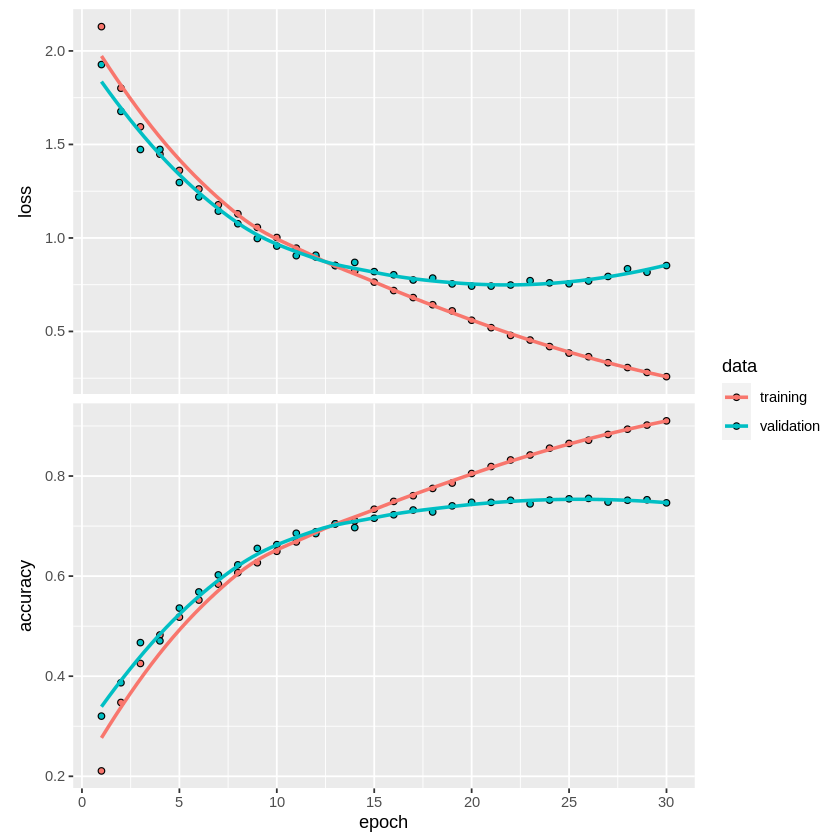

In [8]:
plot(chistory3)

In [9]:
chistory3


Final epoch (plot to see history):
        loss: 0.2583
    accuracy: 0.9103
    val_loss: 0.8525
val_accuracy: 0.7464 

In [68]:
cmodel3 %>% evaluate(x_test, to_categorical(cifar10$test$y, num_classes = 10))

loss  accuracy 
0.8921906 0.7390000

In [71]:
# model prediction
cnn_pred <- cmodel3 %>% predict(x_test) %>% k_argmax()
head(cnn_pred, n=50)

tf.Tensor(
[3 8 8 0 6 6 9 6 3 9 0 9 4 7 9 8 5 7 8 6 7 0 4 9 4 5 5 0 9 6 6 5 4 5 9 8 7
 9 9 5 4 6 7 6 0 9 3 3 7 6], shape=(50), dtype=int64)

### Evaluation

In [119]:
decode <- function(x){
  case_when(x == 0 ~ "airplane",
            x == 1 ~ "automobile",
            x == 2 ~ "bird",
            x == 3 ~ "cat",
            x == 4 ~ "deer",
            x == 5 ~ "dog",
            x == 6 ~ "frog",
            x == 7 ~ "horse",
            x == 8 ~ "ship",
            x == 9 ~ "truck"
            )
}

In [125]:
pred_test <- sapply(as.array(cnn_pred), decode)

In [126]:
true_class <- sapply(as.array(ctest_y), decode)

In [127]:
mean(pred_test==true_class)

[1] 0.739

In [128]:
ctest_y <- sapply(cifar10$test$y,decode)


caret::confusionMatrix(as.factor(pred_test),
                       as.factor(ctest_y))

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


Confusion Matrix and Statistics

            Reference
Prediction   airplane automobile bird cat deer dog frog horse ship truck
  airplane        766          7   53  21   12  12    8     9   43    21
  automobile       23        877    7  14    5   4    6     4   35    77
  bird             46          5  636  77   65  53   32    40   22     9
  cat              14          4   62 530   56 177   28    47   11    12
  deer             40          3  101  74  698  54   27    59   16    12
  dog               5          5   39 111   39 601   13    38    6     9
  frog             13         18   68  96   76  48  862    12   14    15
  horse             5          1   16  32   43  36    2   768    4    12
  ship             62         16   13  17    6   9   15     6  841    22
  truck            26         64    5  28    0   6    7    17    8   811

Overall Statistics
                                          
               Accuracy : 0.739           
                 95% CI : (0.7303, 0

In [ ]:
CrossTable(ctest_y,pred_test)


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  10000 

 
             | pred_test 
     ctest_y |   airplane | automobile |       bird |        cat |       deer |        dog |       frog |      horse |       ship |      truck |  Row Total | 
-------------|------------|------------|------------|------------|------------|------------|------------|------------|------------|------------|------------|
           0 |        835 |          6 |         47 |         19 |          5 |          2 |          9 |          6 |         45 |         26 |       1000 | 
             |   5571.299 |     84.873 |     30.843 |     87.349 |     92.844 |     79.048 |     81.124 |     83.080 |     31.290 |     54.853 |            | 
             |      0.835 |      0.006 |      0.047 |      0.019 |      0.005 | 